# Programming Project #2: Image Quilting

## CS445: Computational Photography


**Texture synthesis** is the creation of a larger texture image from a small sample. For texture synthesis, the main idea is to **sample patches** and lay them down in **overlapping patterns**, such that the overlapping regions are similar. The overlapping regions may not match exactly, which will result in noticeable edges. To fix this, you will compute a path along pixels with similar intensities through the overlapping region and use it to select which overlapping patch from which to draw each pixel.

**Texture transfer** is giving an object the appearance of having the same texture as a sample while preserving its basic shape. Texture transfer is achieved by encouraging **sampled patches** to have similar appearance to a given target image, as well as **matching overlapping regions** of already sampled patches. In this project, you will apply important techniques such as template matching, finding seams, and masking. These techniques are also useful for image stitching, image completion, image retargeting, and blending.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import utils
from utils import cut # default cut function for seam finding section

# # modify to where you store your project data including utils.py
# datadir = "/content/drive/My Drive/cs445_projects/proj2/"

# utilfn = datadir + "utils.py"
# !cp "$utilfn" .
# samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .
# import utils

### Part I: Randomly Sampled Texture (10 pts)

In [33]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    out = np.zeros((out_size, out_size, 3), np.uint8)
    patches = out_size//patch_size
    sh, sw, _ = sample.shape

    for i in range(patches):
        for j in range(patches):
            np.random.seed(0)
            x = np.random.randint(0, sw-patch_size)
            y = np.random.randint(0, sh-patch_size)
            out[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = sample[y:y+patch_size, x:x+patch_size, :]
    
    return out


sample img size: (192, 192, 3)
quilt image size (200, 200, 3)


Text(0.5, 1.0, 'quilt random image')

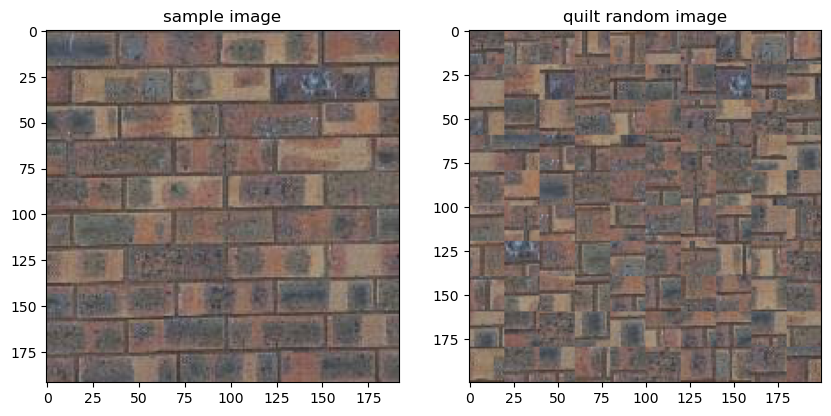

In [34]:
out_size = 200  # change these parameters as needed
patch_size = 20

# load sample img
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
print("sample img size:", sample_img.shape)

# quilt random
res = quilt_random(sample_img, out_size, patch_size)
# res = cv2.cvtColor(res.astype(np.uint8), cv2.COLOR_BGR2RGB)
print("quilt image size", res.shape)

# plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(sample_img)
axes[0].set_title("sample image")
axes[1].imshow(res)
axes[1].set_title("quilt random image")

### Part II: Overlapping Patches (30 pts)

In [127]:
def ssd_patch(T, M, I):
    """
    Performs template matching with the overlapping region, computing the cost of sampling each patch.
    
    :param T: numpy.ndarray   The template, which is the patch in the current output image that is to be filled in.
    :param M: numpy.ndarray   The mask, which has values 1 in the overlapping region, and 0 otherwise.
    :param I: numpy.ndarray   The input texture image.  
    return cost_map: numpy.ndarray   The cost of sampling each patch.
    """
    T, M, I = T.astype(np.float64), M.astype(np.float64), I.astype(np.float64)
    # Compute the SSD for each channel.
    # Each pixel of the ssd_cost gives you the cost for sampling a patch centered around that pixel.
    ssd_costs = []
    for i in range(3):
        cost = ((M[:,:,i] * (T[:,:,i]))**2).sum() - 2 * cv2.filter2D(I[:,:,i], ddepth=-1, kernel=M[:,:,i]*T[:,:,i]) + cv2.filter2D(I[:,:,i]**2, ddepth=-1, kernel=M[:,:,i])
        ssd_costs.append(cost)
    cost_map = np.array(ssd_costs).sum(axis=0)

    # set the ssd cost at the edges as inf
    patch_size = T.shape[0]
    cost_map[:patch_size//2,:] = np.inf # top
    cost_map[-patch_size//2:,:] = np.inf # bottom
    cost_map[:,:patch_size//2] = np.inf # left
    cost_map[:,-patch_size//2:] = np.inf # right

    return np.absolute(cost_map)
    

In [128]:
def choose_sample(cost_map, tol):
    """
    Randomly selects one of the top few samples to avoid getting stuck in local minima in the cost map.
    
    :param cost_map: numpy.ndarray   The cost of sampling each patch.
    :param tol: int                  A tolerance parameter that specifies how many of the top minimum cost samples to randomly choose from.
    :return: tuple                   The coordinates of the top left corner of the patch to be sampled.
    """
    # Find the top few minimum cost samples.
    top_min = np.argpartition(cost_map, tol, axis=None)[:tol]
    # Randomly choose one of the top few minimum cost samples.
    np.random.seed(0)
    idx = np.random.randint(0, tol)
    # Convert the index into a coordinate.
    y, x = np.unravel_index(top_min[idx], cost_map.shape)
    return (y, x)

In [137]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    out = np.zeros((out_size, out_size, 3), np.uint8)
    sh, sw, _ = sample.shape
    step = patch_size - overlap
    num_steps = out_size//step-1
    half = patch_size//2

    # start by randomly sampling a patch for the upper-left corner
    np.random.seed(0)
    x0 = np.random.randint(0, sw-patch_size)
    y0 = np.random.randint(0, sh-patch_size)
    patch0 = sample[y0:y0+patch_size, x0:x0+patch_size, :]
    out[:patch_size, :patch_size, :] = patch0

    # fill in the rest of the image in raster scan order
    for i in range(num_steps):
        for j in range(num_steps):
            # set mask
            if i == 0 and j == 0:
                continue 
            elif i == 0: # first row
                mask = np.zeros((patch_size, patch_size, 3), np.float32)
                mask[:, :overlap, :] = 1
            elif j == 0: # first column
                mask = np.zeros((patch_size, patch_size, 3), np.float32)
                mask[:overlap, :, :] = 1
            else:
                mask = np.zeros((patch_size, patch_size, 3), np.float32)
                mask[:, :overlap, :] = 1
                mask[:overlap, :, :] = 1
            
            # sample new patches and overlap with the existing ones
            template = out[i*step:i*step+patch_size, j*step:j*step+patch_size, :]
            cost_map = ssd_patch(template, mask, sample)
            patch_y, patch_x = choose_sample(cost_map, tol)
            if patch_size%2 == 0:
                patch = sample[patch_y-half:patch_y+half, patch_x-half:patch_x+half, :]
            else:
                patch = sample[patch_y-half:patch_y+half+1, patch_x-half:patch_x+half+1, :]
            out[i*step:i*step+patch_size, j*step:j*step+patch_size, :] = patch
    
    return out


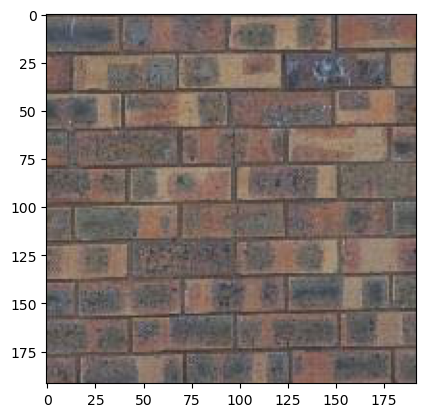

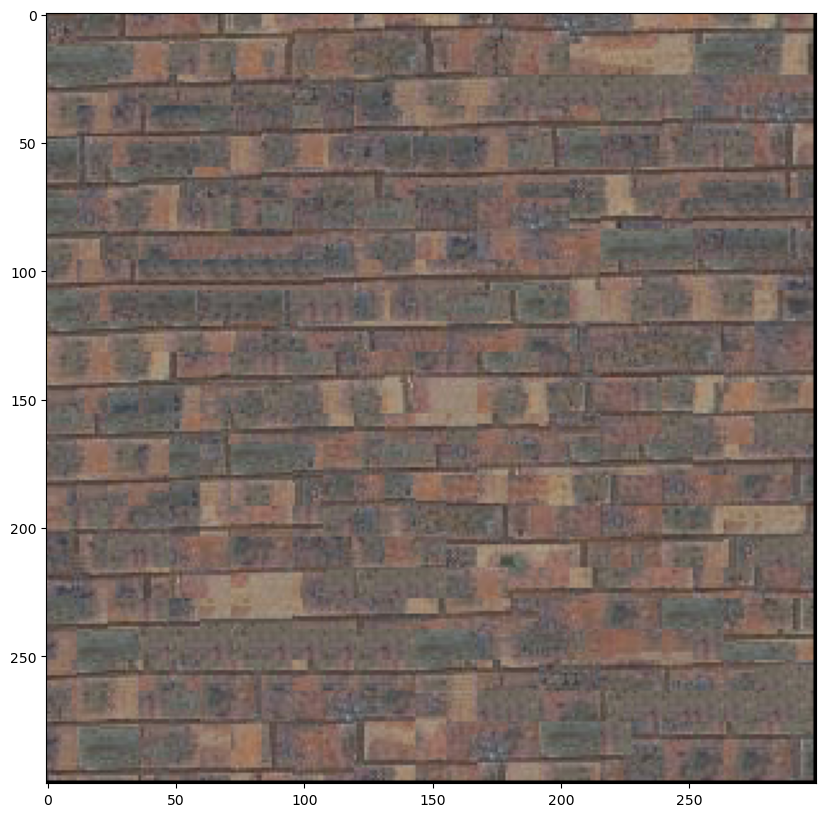

In [142]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 23
overlap = 11 
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results

plt.figure(figsize=(10,10)) 
plt.imshow(res)


### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).